MODEL EXPLAINABILITY & INTERPRETATION


In [3]:
!pip install shap
!pip install "numpy<2.0" --upgrade --force-reinstall


   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
    --------------------------------------- 0.3/15.5 MB ? eta -:--:--
   -- ------------------------------------- 1.0/15.5 MB 3.4 MB/s eta 0:00:05
   ---- ----------------------------------- 1.8/15.5 MB 3.7 MB/s eta 0:00:04
   ------- -------------------------------- 2.9/15.5 MB 4.0 MB/s eta 0:00:04
   --------- ------------------------------ 3.7/15.5 MB 4.2 MB/s eta 0:00:03
   ------------ --------------------------- 4.7/15.5 MB 4.3 MB/s eta 0:00:03
   -------------- ------------------------- 5.8/15.5 MB 4.5 MB/s eta 0:00:03
   ------------------ --------------------- 7.1/15.5 MB 4.6 MB/s eta 0:00:02
   -------------------- ------------------- 7.9/15.5 MB 4.5 MB/s eta 0:00:02
   ---------------------- ----------------- 8.9/15.5 MB 4.7 MB/s eta 0:00:02
   ------------------------- -------------- 10.0/15.5 MB 4.7 MB/s eta 0:00:02
   --------------------------- ------------ 10.7/15.5 MB 4.7 MB/s eta 0:00:02
   --------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.0 which is incompatible.


In [1]:
import numpy
print(numpy.__version__)

1.26.4


In [ ]:
df = pd.read_csv("../data/processed/features_enriched_v2.csv")

                    is_high_amount    amount  amount_zscore_user  \
is_high_amount            1.000000  0.150554            0.489783   
amount                    0.150554  1.000000            0.762393   
amount_zscore_user        0.489783  0.762393            1.000000   
weighted_amount           0.206033  0.901706            0.853081   

                    weighted_amount  
is_high_amount             0.206033  
amount                     0.901706  
amount_zscore_user         0.853081  
weighted_amount            1.000000  


In [20]:
%matplotlib inline

Loading final enriched dataset and tuned model...
✅ Data and model loaded.
Data shape: (10000, 53)

Preprocessing data for SHAP...
✅ Aligned SHAP input features with model: 53

Computing SHAP values...
✅ SHAP values computed.
SHAP value shape: (10000, 53)

Generating SHAP summary plots...


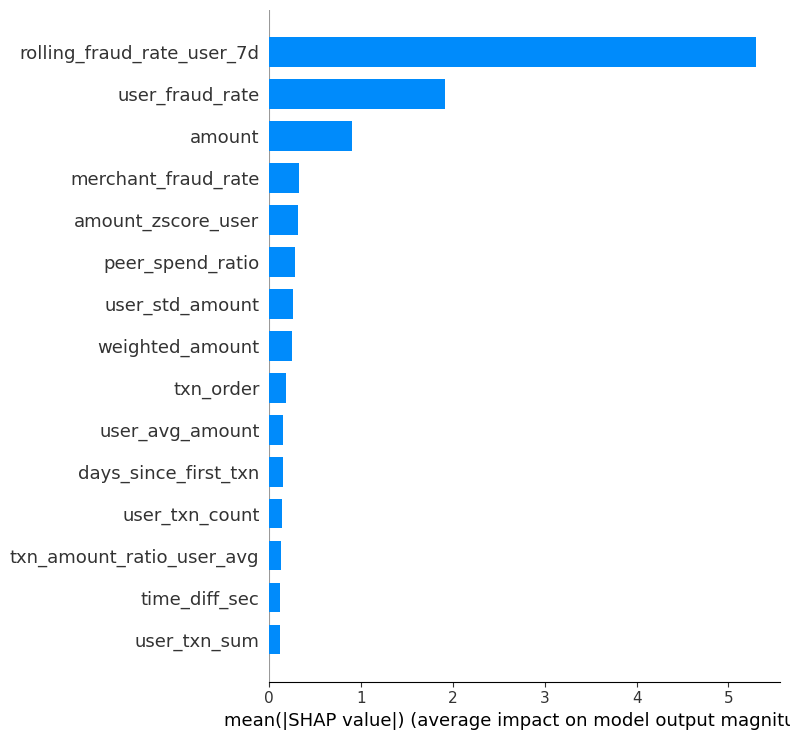

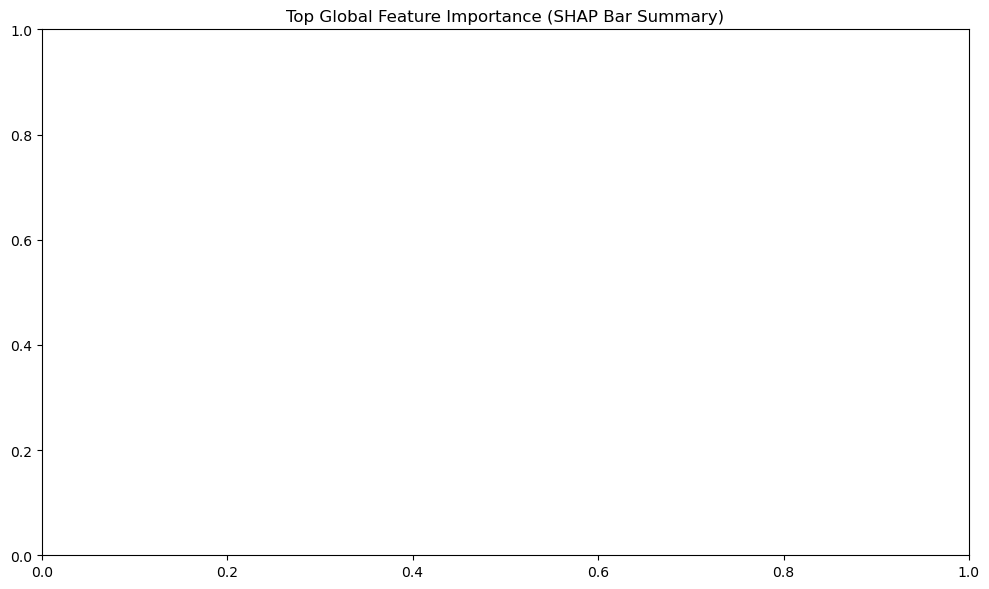

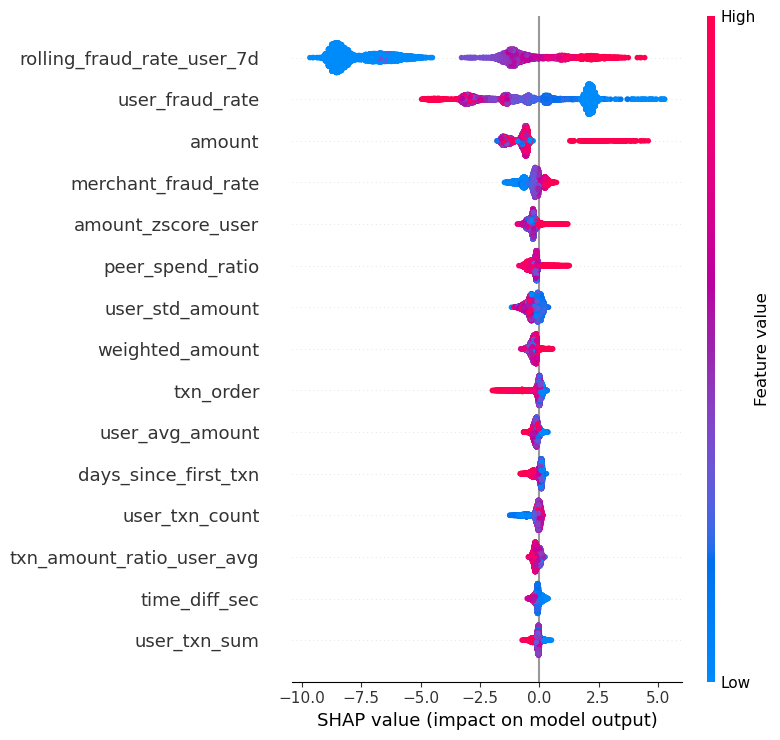

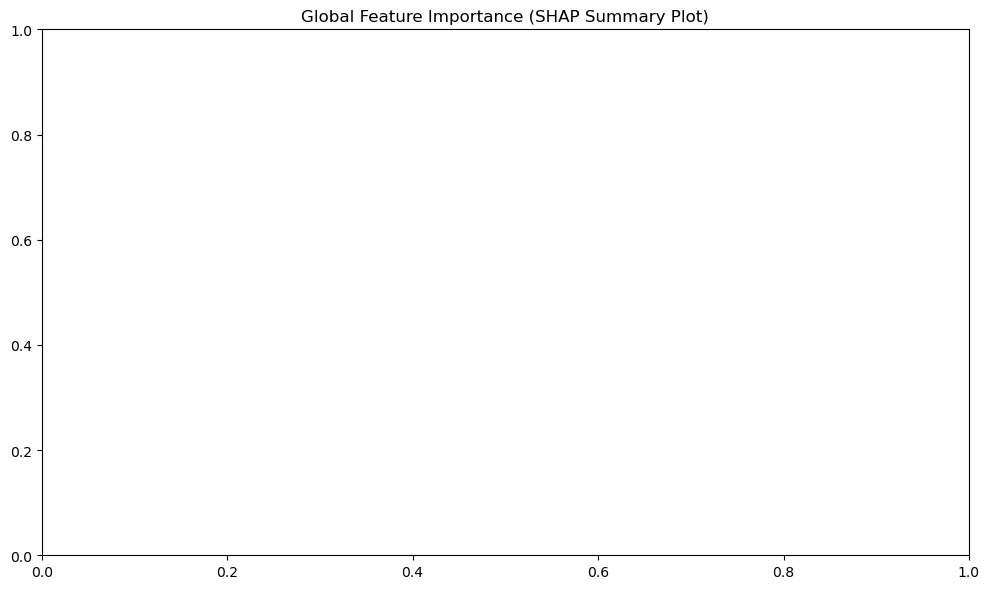


Top 3 Features by SHAP Impact:
 rolling_fraud_rate_user_7d    5.295987
user_fraud_rate               1.911319
amount                        0.898408
dtype: float32
Plotting dependence for: rolling_fraud_rate_user_7d


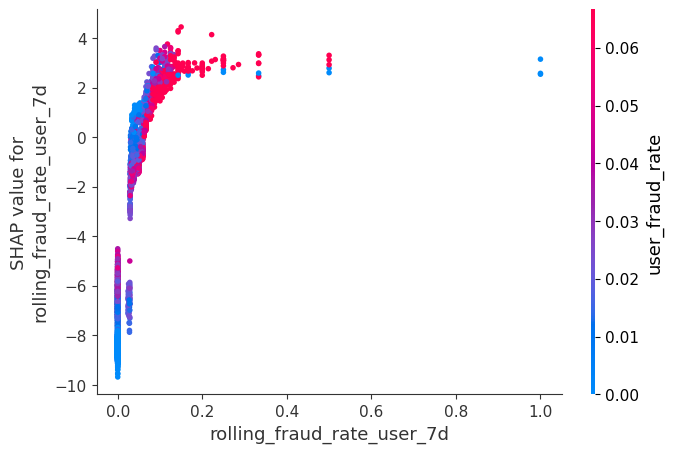

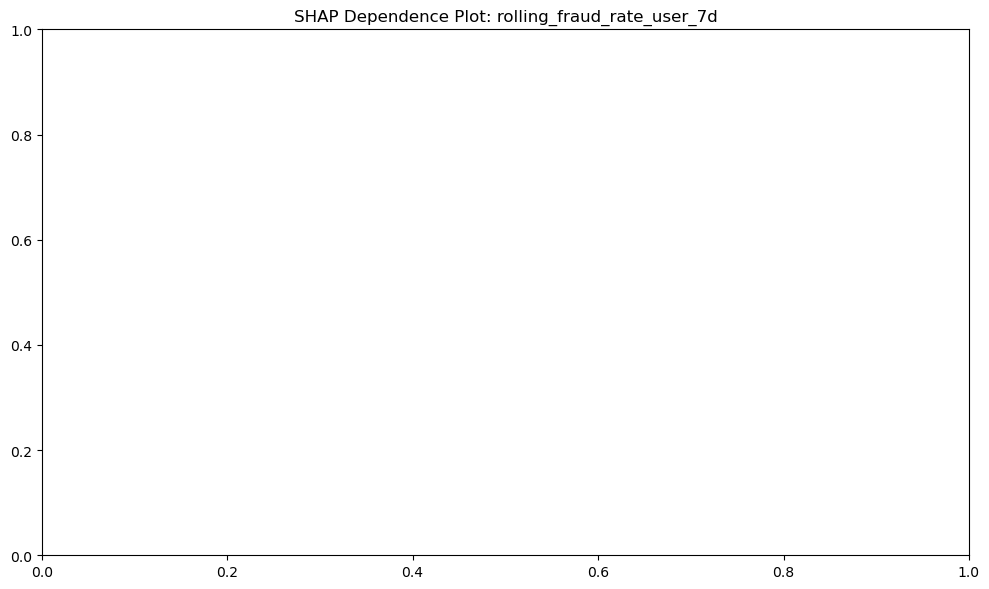

Plotting dependence for: user_fraud_rate


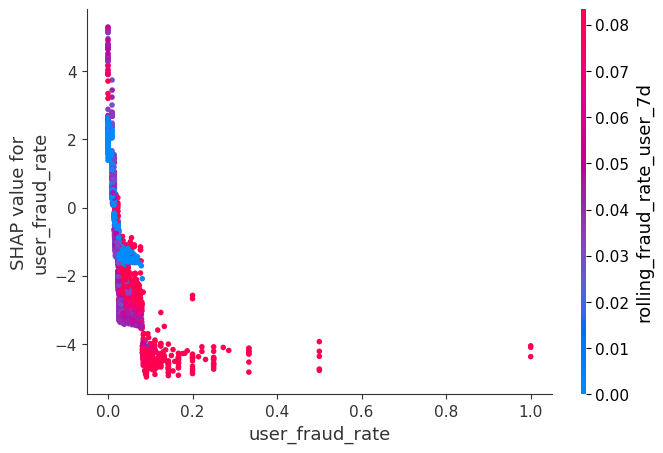

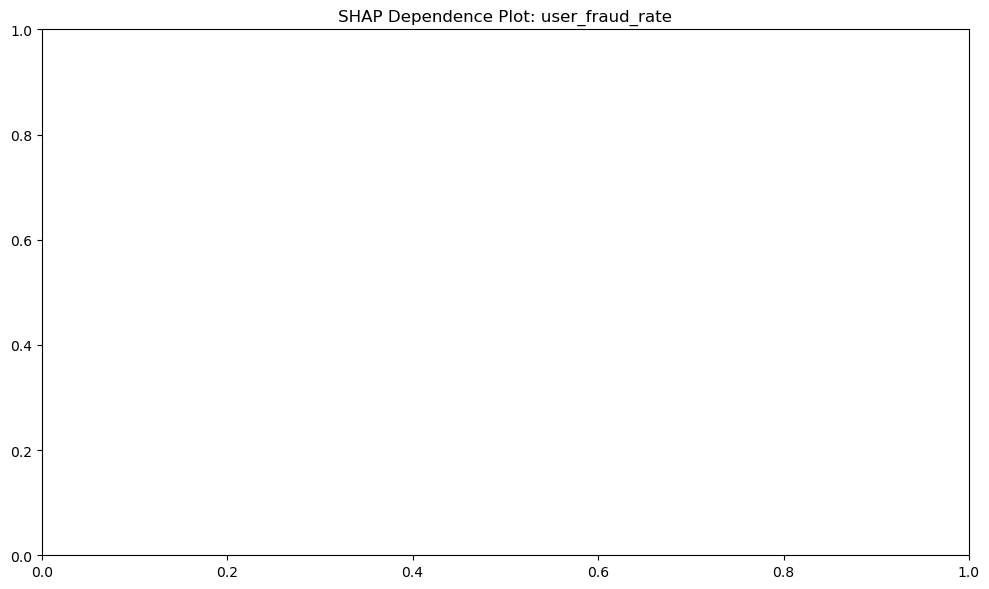

Plotting dependence for: amount


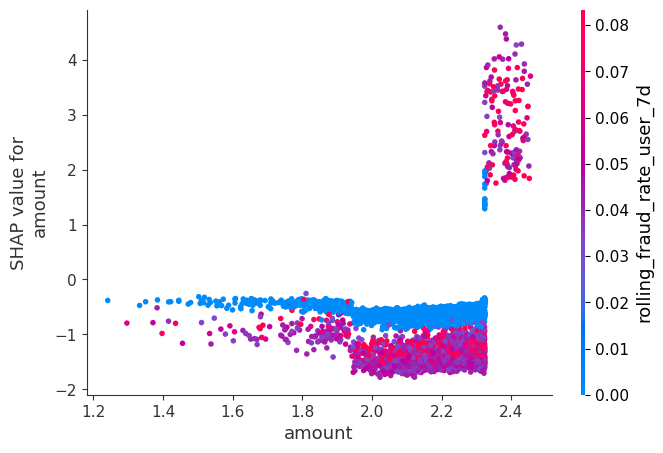

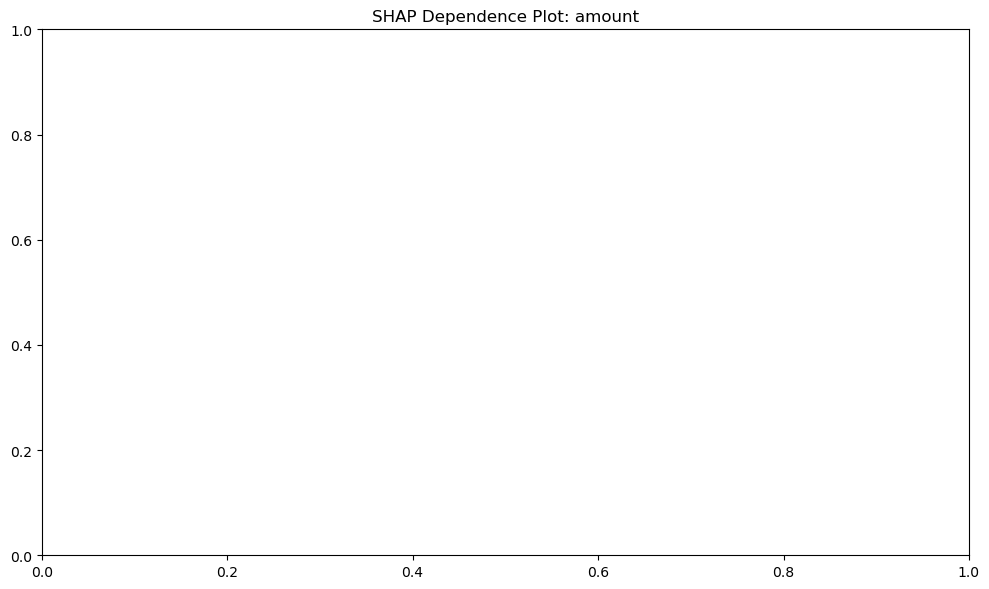


Generating local explanation for one fraud case...


✅ Fraud case 374 explained with SHAP force plot.
✅ Exported shap_feature_importance.csv to ../reports/

📊 Business Interpretations for Top Features:

• rolling_fraud_rate_user_7d: Spike in user's 7-day fraud activity pattern.
• user_fraud_rate: User's historical fraud ratio increases risk score.
• amount: Large-value transactions pose higher risk, especially if inconsistent with user’s norms.
• merchant_fraud_rate: Merchant previously associated with fraud increases risk.
• amount_zscore_user: Transaction amount much higher than user's normal spending range.
• peer_spend_ratio: Deviation from typical peer spending behavior.
• user_std_amount: High variability in spending suggests irregular behavior.
• weighted_amount: High-value transactions weighted by contextual risk factors.
• txn_order: Recent transactions have higher influence on fraud risk.
• user_avg_amount: Baseline spending level; large deviations are risky.

✅ Explainability & interpretation completed successfully.


In [26]:

# Project: Mobile Payment Real-Time Fraud Analytics
# Author: Virender Machra


import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Ensure plots render inline (important in Jupyter/VSCode)
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 12

print("Loading final enriched dataset and tuned model...")

df = pd.read_csv("../data/processed/features_enriched_v2.csv")

# Properly drop timestamp (inplace)
if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)

y = df["is_fraud"]
X = df.drop(columns=["is_fraud"], errors="ignore")

# Load tuned XGBoost model
model = joblib.load("../models/xgboost_tuned.pkl")

print("✅ Data and model loaded.")
print("Data shape:", X.shape)

print("\nPreprocessing data for SHAP...")

# Drop any non-numeric columns
non_numeric_cols = X.select_dtypes(include=["object"]).columns.tolist()
if non_numeric_cols:
    print("Dropping non-numeric columns for SHAP analysis:", non_numeric_cols)
    X = X.drop(columns=non_numeric_cols, errors="ignore")

# Align feature order with model
model_features = model.get_booster().feature_names
X = X[model_features]
print("✅ Aligned SHAP input features with model:", len(model_features))

# Ensure numeric conversion
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

print("\nComputing SHAP values...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

print("✅ SHAP values computed.")
print("SHAP value shape:", np.array(shap_values).shape)

print("\nGenerating SHAP summary plots...")

# Global importance (bar plot)
plt.figure()
shap.summary_plot(shap_values, X, plot_type="bar", max_display=15, show=True)
plt.title("Top Global Feature Importance (SHAP Bar Summary)")
plt.tight_layout()
plt.show()

# Detailed summary (beeswarm)
plt.figure()
shap.summary_plot(shap_values, X, max_display=15, show=True)
plt.title("Global Feature Importance (SHAP Summary Plot)")
plt.tight_layout()
plt.show()

mean_abs_shap = pd.DataFrame(np.abs(shap_values), columns=X.columns).mean().sort_values(ascending=False)
top_features = mean_abs_shap.head(3)

print("\nTop 3 Features by SHAP Impact:\n", top_features)

for feat in top_features.index:
    print(f"Plotting dependence for: {feat}")
    shap.dependence_plot(feat, shap_values, X, show=True)
    plt.title(f"SHAP Dependence Plot: {feat}")
    plt.tight_layout()
    plt.show()


print("\nGenerating local explanation for one fraud case...")

fraud_case_idx = y[y == 1].sample(1, random_state=42).index[0]
fraud_case = X.loc[[fraud_case_idx]]

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[fraud_case_idx, :],
    X.iloc[fraud_case_idx, :],
)
print(f"✅ Fraud case {fraud_case_idx} explained with SHAP force plot.")


output_shap = pd.DataFrame({
    "Feature": mean_abs_shap.index,
    "Mean_SHAP_Impact": mean_abs_shap.values
})
output_shap.to_csv("../reports/shap_feature_importance.csv", index=False)
print("✅ Exported shap_feature_importance.csv to ../reports/")


business_map = {
    "rolling_fraud_rate_user_7d": "Spike in user's 7-day fraud activity pattern.",
    "user_fraud_rate": "User's historical fraud ratio increases risk score.",
    "amount": "Large-value transactions pose higher risk, especially if inconsistent with user’s norms.",
    "merchant_fraud_rate": "Merchant previously associated with fraud increases risk.",
    "amount_zscore_user": "Transaction amount much higher than user's normal spending range.",
    "peer_spend_ratio": "Deviation from typical peer spending behavior.",
    "user_std_amount": "High variability in spending suggests irregular behavior.",
    "weighted_amount": "High-value transactions weighted by contextual risk factors.",
    "txn_order": "Recent transactions have higher influence on fraud risk.",
    "user_avg_amount": "Baseline spending level; large deviations are risky.",
}

print("\n📊 Business Interpretations for Top Features:\n")
for feat in mean_abs_shap.head(10).index:
    explanation = business_map.get(feat, "Feature interpretation not predefined.")
    print(f"• {feat}: {explanation}")

print("\n✅ Explainability & interpretation completed successfully.")
